## Kaggle CLI

In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d saurabh502/zindi-weekend-vaccine

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/795k [00:00<?, ?B/s]
100% 795k/795k [00:00<00:00, 51.9MB/s]


**Installing Extra Dependencies**

In [0]:
# !pip install simpletransformers

### Imports

In [0]:
import numpy as np
import pandas as pd
from simpletransformers.classification.classification_model import ClassificationModel
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import *

In [0]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')
ID_COL, TARGET_COL = sub.columns.tolist()

### Data Clean up of train and test set

In [0]:
train=train[train.label.isin([0,1,-1])]
train.append(pd.Series(['RQMQ0L2A','I cannot believe in this day and age some parents could be so oblivious to reality as to not #vaccinate their child. #lawandorderSVU',1,0.666667], index=train.columns ), ignore_index=True)
train['label']=train['label']*train['agreement']

test.iloc[2024]['tweet_id']='E0GRUEO2'
test.iloc[2024]['safe_text']='Dr. JAMES SHANNON'
test['safe_text'] = test['safe_text'].fillna('Others')

## Some Data Insights

In [0]:
df=train.append(test,ignore_index=True)
import string
punctuation=string.punctuation
df['safe_text']=df['safe_text'].astype('category')
df['word_count']=df['safe_text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['safe_text'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['safe_text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['numerics'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['safe_text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
df['hastag_count'] = df['safe_text'].apply(lambda x: len("".join(_ for _ in x if _=="#"))) 

df.groupby('label').mean()

,agreement,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count,hastag_count
label,,,,,,,,,,
-1.000000,1.000000,17.167539,103.835079,5.296344,4.921466,0.185864,1.023560,5.800377,6.115183,0.623037
-0.666667,0.666667,16.851319,103.304556,5.357784,4.532374,0.153477,0.798561,5.880074,6.203837,0.549161
-0.333333,0.333333,17.087866,103.761506,5.308754,4.560669,0.100418,0.853556,5.803522,6.092050,0.359833
0.000000,0.881282,15.591891,95.639772,5.327839,3.808883,0.127954,0.827221,5.792939,5.761410,0.637531
0.666667,0.666667,16.980335,103.918450,5.341897,4.694043,0.124349,0.723540,5.860056,5.700405,0.453441
1.000000,1.000000,17.107573,104.343373,5.316161,5.196644,0.118761,0.727194,5.833992,5.629518,0.469449


In [0]:
test['safe_text'].apply(len).mean()

99.50647092910953

### Data Preprocessing

In [0]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
punctuation=string.punctuation
from bs4 import BeautifulSoup
!pip install emoji
import emoji
def url_to_words(raw_text):
    raw_text=str(raw_text).strip()
    soup = BeautifulSoup(raw_text, 'html.parser')
    raw_text = soup.text
    raw_text = emoji.demojize(raw_text)
    no_coms=re.sub(r'\.com','',raw_text)
    no_urls=re.sub('https?://www','',no_coms)
    no_urls1=re.sub('https?://','',no_urls)
    try:
        no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        no_encoding = no_urls1
    # letters_only = re.sub("[^a-zA-Z0-9]", " ",no_encoding) 
    words = no_encoding.lower().split()                             
    # stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words] 
    return( " ".join( meaningful_words ))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
tr = pd.DataFrame()
tr['text'] = train['safe_text'].apply(url_to_words)
tr['labels'] = train['label']


In [0]:
train['safe_text'].values

array(['Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>',
       "I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day",
       '#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD', ...,
       'Interesting trends in child immunization in Oklahoma from <user> covering the <user> meeting.',
       'CDC Says Measles Are At Highest Levels In Decades: (<url> have returned in the U.S. to... <url>',
       'Pneumonia vaccine: for women w risk of pulmonary disease, see this ACOG tweet  <url>'],
      dtype=object)

In [0]:
tr['text'].values

array(['me & the big homie meanboy3000 #meanboy #mb #mbs #mmr #stegmanlife @ stegman st.',
       "i'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day",
       '#whatcausesautism vaccines, do not vaccinate your child', ...,
       'interesting trends in child immunization in oklahoma from covering the meeting.',
       'cdc says measles are at highest levels in decades: ( have returned in the u.s. to...',
       'pneumonia vaccine: for women w risk of pulmonary disease, see this acog tweet'],
      dtype=object)

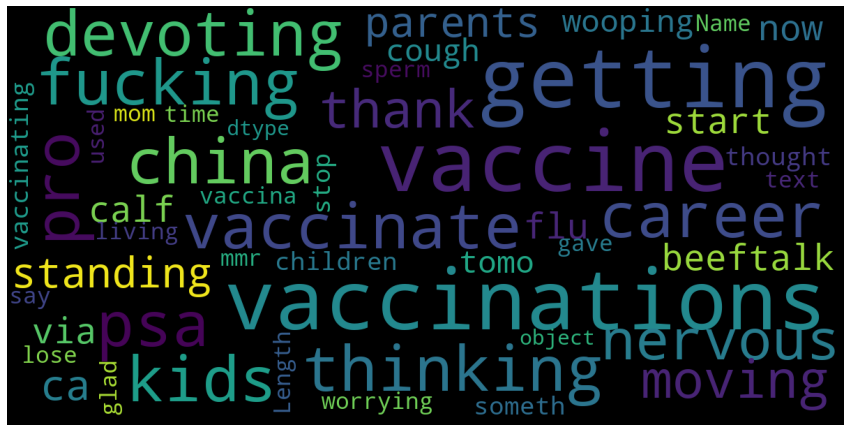

In [0]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(tr[tr.labels==1]['text'])

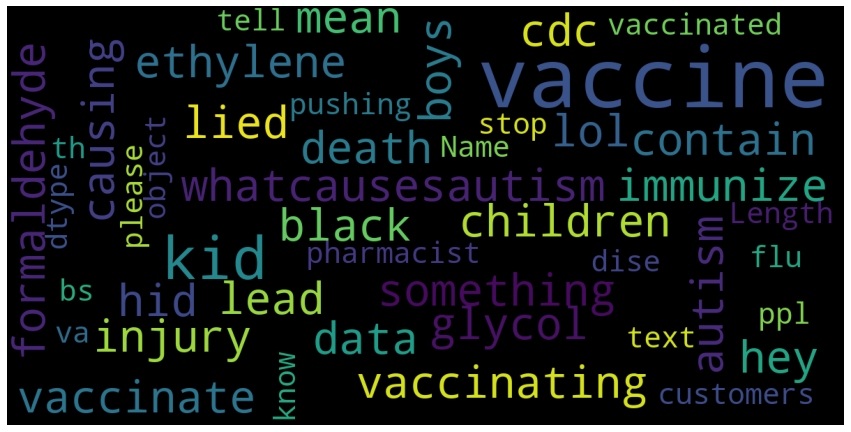

In [0]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(tr[tr.labels==-1]['text'])

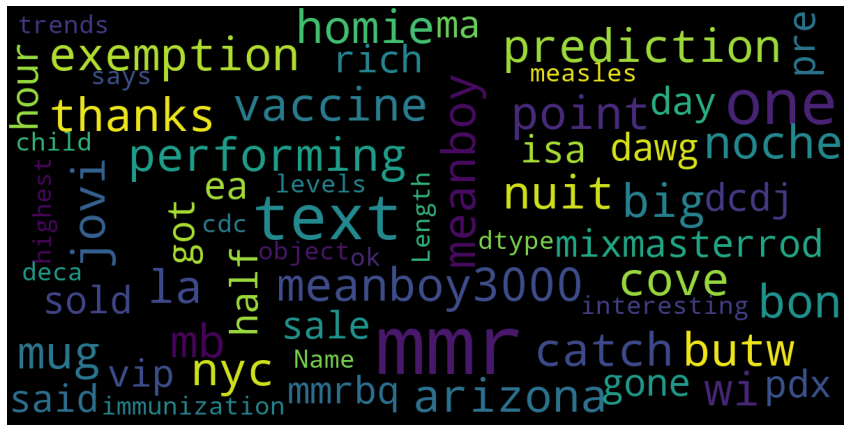

In [0]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(tr[tr.labels==0]['text'])

In [0]:
test['safe_text'] = test['safe_text'].apply(url_to_words)
ts=pd.DataFrame()
ts['text']=test['safe_text']
ts['labels'] = 0

In [0]:
y=pd.qcut(tr['labels'],3,labels=False)

## Transformers

In [0]:
tr_trn, tr_val = train_test_split(tr, test_size=0.2, stratify =y,random_state=1994)

# err=[]
# y_pred_tot=[]

# from sklearn.model_selection import KFold,StratifiedKFold
# fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
# i=1
# for train_index, test_index in fold.split(tr,y):
    
#     X_train, X_test = tr.iloc[train_index], tr.iloc[test_index]
#     print(X_train.shape,X_test.shape)
#     model.train_model(X_train)
#     preds_val = model.eval_model(X_test)
#     print(f"RMSE: {mse(X_test['labels'], preds_val[1])**0.5}")
#     err.append(np.sqrt(mse(X_test['labels'], preds_val[1])))
#     test_preds = model.eval_model(ts)[1]
#     y_pred_tot.append(test_preds)
    

# model = ClassificationModel('roberta','roberta-base',num_labels=1, args={'regression': True, 'fp16': False,'warmup_ratio':0.2,
#                                                                          'overwrite_output_dir':True,'reprocess_input_data':True,
#                                                                          'max_seq_length':128,'manual_seed':2020,
#                                                                          'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':16}) #wghtdecay:5
# model = ClassificationModel('xlnet','xlnet-base-cased',num_labels=1, args={'regression': True, 'fp16': False,
#                                                                          'overwrite_output_dir':True,'reprocess_input_data':True,
#                                                                          'max_seq_length':128,'manual_seed':2020,
#                                                                          'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':16}) #wghtdecay:5

# model = ClassificationModel('roberta','roberta-base',num_labels=1, args={'regression': True, 'fp16': False,
#                                                                          'overwrite_output_dir':True,'reprocess_input_data':True,
#                                                                          'max_seq_length':150,
#                                                                          'num_train_epochs': 2,'manual_seed':1994})

# model2 = ClassificationModel('camembert','camembert-base',num_labels=1, args={'regression': True, 'fp16': False,
#                                                                          'overwrite_output_dir':True,'reprocess_input_data':True,
#                                                                          'max_seq_length':128,'manual_seed':2020,
#                                                                          'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':16}) #wghtdecay:5
# model2 = ClassificationModel('bert','bert-base-uncased',num_labels=1, args={'regression': True, 'fp16': False,
#                                                                          'overwrite_output_dir':True,'reprocess_input_data':True,
#                                                                          'max_seq_length':128,'manual_seed':2020,
#                                                                          'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':8}) #wghtdecay:5
# preds_val_2
# model.train_model(tr_trn)
# preds_val = model.eval_model(tr_val)[1]
# print(f"RMSE: {mse(tr_val['labels'], preds_val)**0.5}")

In [0]:
model = ClassificationModel('roberta','roberta-base',num_labels=1, args={'regression': True, 'fp16': False,'warmup_ratio':0.2,
                                                                         'overwrite_output_dir':True,'reprocess_input_data':True,
                                                                         'max_seq_length':128,'manual_seed':2020,
                                                                         'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':16}) #wghtdecay:5

model.train_model(tr)
preds_val = model.eval_model(ts)[1]


Running loss: 0.417365

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.354841


Running loss: 0.260035


Running loss: 0.271051


Running loss: 0.143314


Running loss: 0.077106


Running loss: 0.024349



In [0]:
model2 = ClassificationModel('roberta','roberta-base',num_labels=1, args={'regression': True, 'fp16': False,
                                                                         'overwrite_output_dir':True,'reprocess_input_data':True,
                                                                         'max_seq_length':128,'manual_seed':2021,
                                                                         'num_train_epochs': 3,'weight_decay':10,'do_lower_case':False,'train_batch_size':16}) #wghtdecay:5

model2.train_model(tr)
preds_val_2 = model2.eval_model(ts)[1]

Running loss: 0.284442

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.158736


Running loss: 0.089289


Running loss: 0.211398



In [0]:
model3 = ClassificationModel('roberta','roberta-base',num_labels=1, args={'regression': True, 'fp16': False,
                                                                         'overwrite_output_dir':True,'reprocess_input_data':True,
                                                                         'max_seq_length':128,'manual_seed':2020,
                                                                         'num_train_epochs': 3,'weight_decay':5,'do_lower_case':False,'train_batch_size':16}) #wghtdecay:5

model3.train_model(tr)
preds_val_3 = model3.eval_model(ts)[1]

In [0]:
# test_preds*0.7+test_preds2*0.3
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = preds_val
preds_df_final.to_csv('roberta_cl_b16_e3_wt5_2020_wr0.2.csv', index=False) #0.494914919523458

preds_df_final.head(10)

,tweet_id,label
0,00BHHHP1,0.229492
1,00UNMD0E,0.123250
2,01AXPTJF,0.040119
3,01HOEQJW,0.960286
4,01JUKMAO,0.180800
5,01V1X8XW,0.972352
6,01VCVYR0,0.090214
7,01VO7KBO,0.361785
8,020SYHIL,0.778537
9,02CQIJUI,0.024150


In [0]:
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = preds_val_3
preds_df_final.to_csv('roberta_b16_e3_wt5_2020.csv', index=False) #49.68
preds_df_final.head(10)

,tweet_id,label
0,00BHHHP1,-0.089006
1,00UNMD0E,0.194693
2,01AXPTJF,0.034129
3,01HOEQJW,0.956601
4,01JUKMAO,0.094548
5,01V1X8XW,0.950979
6,01VCVYR0,0.056374
7,01VO7KBO,0.755803
8,020SYHIL,0.911721
9,02CQIJUI,0.013222


In [0]:
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = preds_val_2
preds_df_final.to_csv('roberta_b16_e3_wt10_2021.csv', index=False) #50.24
preds_df_final.head(10)

,tweet_id,label
0,00BHHHP1,0.781206
1,00UNMD0E,0.440125
2,01AXPTJF,0.072076
3,01HOEQJW,0.942428
4,01JUKMAO,0.291293
5,01V1X8XW,0.937564
6,01VCVYR0,0.021259
7,01VO7KBO,0.390584
8,020SYHIL,0.939905
9,02CQIJUI,0.026405


In [0]:
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = preds_val*0.8+preds_val_2*0.2
preds_df_final.to_csv('roberta_b16_e3_wt10_2021_x2_b16_e3_wt5_2020_x8.csv', index=False) #49.32
preds_df_final.head(10)

,tweet_id,label
0,00BHHHP1,0.085036
1,00UNMD0E,0.243779
2,01AXPTJF,0.041718
3,01HOEQJW,0.953766
4,01JUKMAO,0.133897
5,01V1X8XW,0.948296
6,01VCVYR0,0.049351
7,01VO7KBO,0.682759
8,020SYHIL,0.917358
9,02CQIJUI,0.015858


## Ensemble

In [0]:
kv1=pd.read_csv('roberta_b16_e3_wt10_2021_x2_b16_e3_wt5_2020_x8.csv') #49.32
kv2=pd.read_csv('roberta_b16_e3_wt5_2020.csv') #49.68
#kv3=pd.read_csv('xlnet_b16_e2_01_trbtch16_e3_06_roberta_b16_e3_03.csv') #49.73
kv4=pd.read_csv('roberta_cl_b16_e3_wt5_2020_wr0.2.csv') #49.49
#kv5=pd.read_csv('ensemble_2.csv') #48.98



#kv1['label']=kv2['label']*0.3+kv3['label']*0.1+kv1['label']*0.6
#kv1.to_csv('ensemble_1.csv',index=False) #49.24
#kv1.to_csv('xlnet_b16_e2_01_trbtch16_e3_06_roberta_b16_e3_03.csv',index=False)


kv1['label']=kv1['label']*0.5+kv4['label']*0.5
kv1.to_csv('ensemble_4.csv',index=False) #49.01